In [2]:
!git clone https://github.com/Khanhnvtb/Text-to-image

Cloning into 'Text-to-image'...
remote: Enumerating objects: 5924, done.
remote: Counting objects: 100% (430/430), done.
remote: Compressing objects: 100% (428/428), done.
remote: Total 5924 (delta 3), reused 426 (delta 2), pack-reused 5494
Receiving objects: 100% (5924/5924), 685.98 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
%cd Text-to-image

/content/Text-to-image


In [4]:
import numpy as np
import pandas as pd
import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop(['label'], axis=1).values.reshape(-1, 28,28) / 255
y = train_df['label'].values

X_test = test_df.values.reshape(-1, 28,28) / 255

In [5]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=10, output_dim=10)(label_input)
x = Reshape((10,))(x)
x = concatenate([x, latent_input], axis=-1)
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7,7,128))(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28,))(x)
generator = Model(inputs=[latent_input, label_input], outputs=x)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 10)           0           ['embedding[0][0]']              
                                                                                                  
 latent_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                              

In [6]:
img_input = Input(shape=(28,28,))
x = Reshape((28,28,1))(img_input)
x = Conv2D(16, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(11, activation='softmax')(x)
discriminator = Model(inputs=img_input, outputs=x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 16)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          4640      
                                                           

In [7]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = generator([latent_input, label_input])
x = discriminator(x)
gan = Model(inputs=[latent_input, label_input], outputs=x)
discriminator.trainable = False
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 28, 28)       789221      ['latent_input[0][0]',           
                                                                  'label_input[0][0]']            
                                                                                                  
 model_1 (Functional)           (None, 11)           103755      ['model[0][0]']            

In [8]:
discriminator.trainable = True
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.trainable = False
gan.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.0003))

In [9]:
def random_mnist_set(X, y, size=10):
    length = len(X)
    indices = np.random.choice(length, size)
    return X[indices], y[indices]

def random_generated_set(generator, size=10):
    latents = np.random.normal(0, 1, (size, 100))
    return generator.predict_on_batch({'latent_input':latents,
                      'label_input':np.random.randint(10, size=size)})

In [10]:
save_interval = 300
epochs = save_interval*10+1
batch_size=20
history = {'dloss':[], 'gloss':[]}
for iteration in range(epochs):
    discriminator.trainable=True
    X_sample, y_sample = random_mnist_set(X, y, batch_size)
    dloss_real = discriminator.train_on_batch(X_sample, y_sample)
    dloss_fake = discriminator.train_on_batch(random_generated_set(generator, size=batch_size), np.full(batch_size, 10))

    discriminator.trainable=False

    gan_labels = np.random.randint(10, size=batch_size)
    gloss = gan.train_on_batch({'latent_input':np.random.normal(0, 1, (batch_size, 100)),
                        'label_input':gan_labels},
                       gan_labels)

    history['dloss'].append((dloss_real[0]+dloss_fake[0])/2)
    history['gloss'].append(gloss[0])
    if iteration % save_interval == 0:
        print('generator: loss={}. acc={}'.format(gloss[0], gloss[1]))
        print('discriminator: loss_real={}, acc_real={}'.format(dloss_real[0],dloss_real[1]))
        print('    loss_fake={}, acc_fake={}'.format(dloss_fake[0],dloss_fake[1]))
        generator.save_weights('generator_{0:05d}.h5'.format(iteration))

generator: loss=2.401942729949951. acc=0.05000000074505806
discriminator: loss_real=3.275681734085083, acc_real=0.05000000074505806
    loss_fake=3.3282158374786377, acc_fake=0.0
generator: loss=0.764270544052124. acc=0.6499999761581421
discriminator: loss_real=0.4968965947628021, acc_real=0.8500000238418579
    loss_fake=0.010231556370854378, acc_fake=1.0
generator: loss=0.49340933561325073. acc=0.800000011920929
discriminator: loss_real=0.15403179824352264, acc_real=0.949999988079071
    loss_fake=0.0002761280338745564, acc_fake=1.0
generator: loss=1.513816237449646. acc=0.550000011920929
discriminator: loss_real=0.12321202456951141, acc_real=0.949999988079071
    loss_fake=0.02433907799422741, acc_fake=1.0
generator: loss=0.2849244773387909. acc=0.8500000238418579
discriminator: loss_real=0.13969865441322327, acc_real=0.949999988079071
    loss_fake=0.00036794523475691676, acc_fake=1.0
generator: loss=0.2025640904903412. acc=0.8999999761581421
discriminator: loss_real=0.044172041118

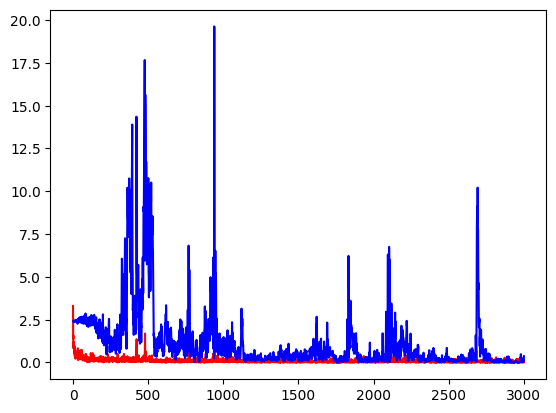

In [11]:
plt.plot(history['dloss'], 'r')
plt.plot(history['gloss'], 'b')

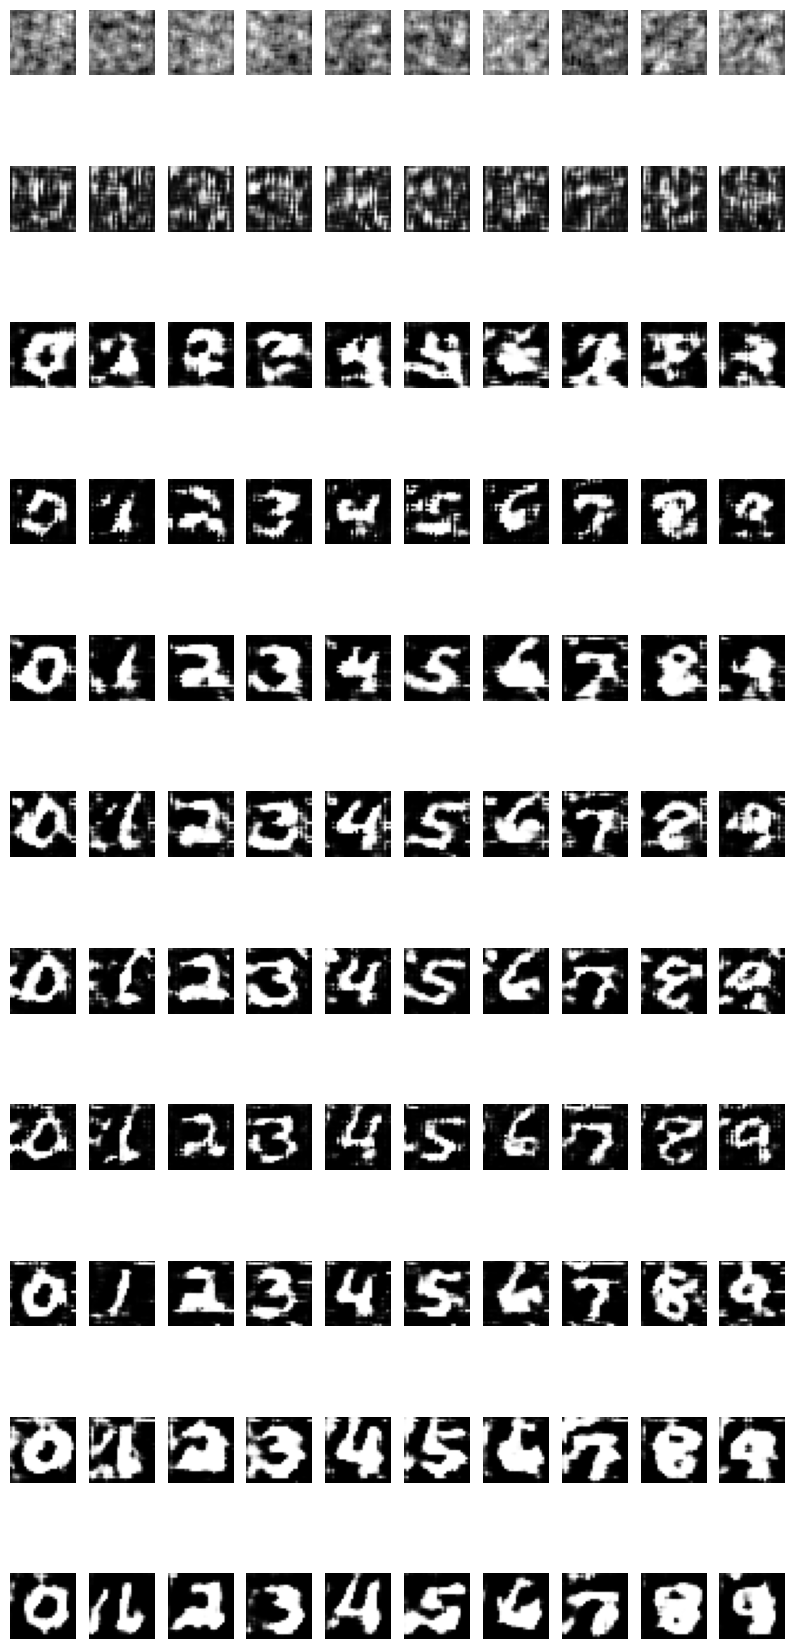

In [12]:
checkpoints = sorted(glob.glob('generator_*.h5'))

plt.figure(figsize=(10,2*len(checkpoints)))
for i,cp in enumerate(checkpoints):
    generator.load_weights(cp)
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')

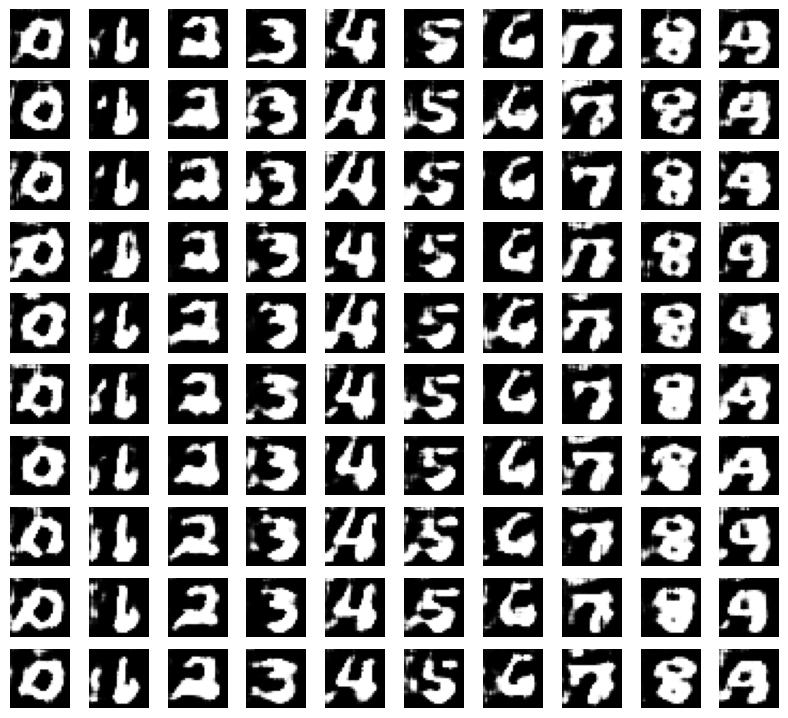

In [13]:
generator.load_weights(checkpoints[-1])
plt.figure(figsize=(10,10))
for i in range(10):
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')

In [ ]:
generator.save('model_gan.h5')

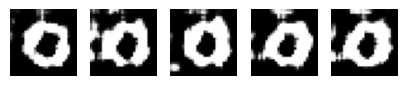

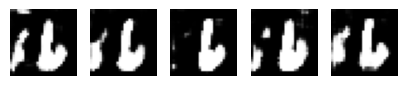

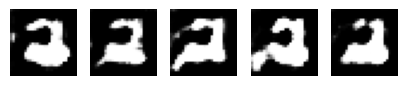

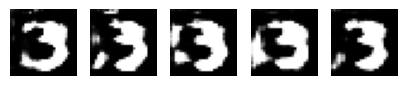

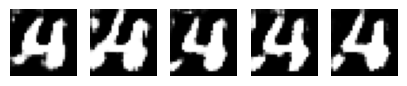

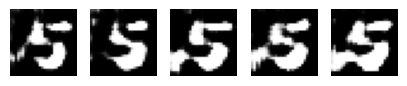

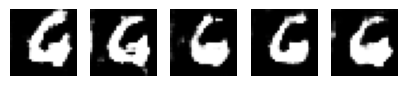

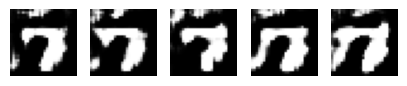

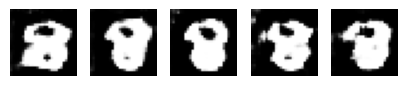

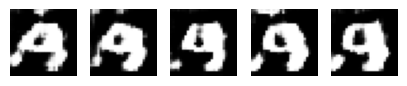

In [14]:
def get_image(generator, label, num_images=1):
    latent_samples = np.random.normal(0, 1, (num_images, 100))
    label_samples = np.full(num_images, label)
    generated_images = generator.predict_on_batch({'latent_input': latent_samples,
                                                   'label_input': label_samples})
    return generated_images

# Load the generator model
generator.load_weights('generator_03000.h5')

for i in range(10):

    # Generate images with label 5
    label = i
    num_images = 5
    generated_images = get_image(generator, label, num_images)

    # Display the generated images
    plt.figure(figsize=(num_images, 1))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()
